In [1]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm
import torch
import torch.nn as nn

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, MiniBatchSparsePCA
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import time
import warnings

warnings.filterwarnings('ignore')

from collections import Counter

cwd = os.getcwd()
cwd

'C:\\Users\\LSB\\Desktop\\넥토리얼_분석가과제'

MY INSIGHT:

0) game feature 차이에 따라 \
    -- [1] match_count(일일 게임 플레이횟수 총합) > game A, game B는 없음. game C만 있음 \
        ---- 1. game A, game B는 RPG 게임: 게임 캐릭터를 키워가는 게임 \
        ---- 2. game C는 레이싱, 아케이드, RTS 등의 다른 타입 \
    -- [2]
    
1) game A와 game B의 게임 상의 특성을 알아내기 어려움
    예를 들어, \
    -- [1] A게임의 'look_count'가 엄청 높은데 B게임의 'look_count'가 낮다고 가정한다면, A게임은 룩딸(캐릭터 꾸미는 행위)이 자유로운 게임이고, B게임은 룩딸이 잘 안되는 게임인걸로 해석 가능 \
    -- [2] 해당 게임이 'max_level'이 낮으면서 'dead_count'가 높은 게임이라면, 그 게임은 진입장벽이 높은 게임. --> 이건 유저의 특성으로도 연결 가능 \
    -- [3] 해당 게임이 'party_count'가 높다면, 그 게임은 파티 위주의 게임일 확률 높음 --> 유저의 특성에 따라 해당 게임에 대한 선호도 파악 가능 \
    \* 하지만 공통된 유저가 900여명 정도밖에 되지 않고, 현재 유저풀이 아주 다름.
    
2) game feature를 봤을 때, RPG인 것 같음.

3) 게임 유저들의 특성에 맞게 feature를 고르고자 함:
    예를 들어, \
    -- [1] 친목활동을 좋아하는 유저 >>> 'look_count', 'chat_count'가 높은 유저 \
    -- [2] 캐릭터를 꾸미는 걸 좋아하는 유저 >>> 'look_count'가 높은 유저 \
    -- [3] 렙업 무쟈게 해서 강해지는 거에 재미를 느끼는 유저 >>> 'max_level', 'itemget_count', 'itemuse_count', 'party_count', 'dungeon_count'가 높은 유저\
    -- [4] 퀘스트, 스토리 위주로 즐기는 유저 >>> 'quest_count', 'npc_count'가 높은 유저 \
    -- [5] 하드코어 선호 유저 >>> 'max_level'이 낮으면서 'dead_count'가 높은 유저 ⭐️⭐️⭐️ 전반적인 게임 특성인지도 파악해보기 !!! ⭐️⭐️⭐️ \
    -- [6] 파티 선호 유저 >>> 'party_count'가 높은 유저: 파티 위주의 게임을 선호할 가능성 높음 \
    -- [7] 숙제만 하고 있는 유저 >>> daily 'totalplaytime'이 낮으면서 'quest_count'가 일정한 유저: 게임 머니 얻을 목적으로 귀찮지만 매일매일 접속해서 퀘스트만 깨고 게임 종료하는 유저 \
    --         -> e.g. game A, game B 둘다 이런 모습이 보이는 경우, 이 유저에게는 game C 추천 가능

In [2]:
data_dir = os.path.join(cwd, 'UX선행기획팀')

output = pd.read_csv(os.path.join(data_dir, 'output_sample.csv'))
output

,A게임 유저ID,B게임 플레이시 한달간 누적 플레이 예측 시간(분),B게임 플레이시 열성적인 플레이어가 될 확률,C게임 플레이시 한달간 누적 플레이 예측 시간(분),C게임 플레이시 열성적인 플레이어가 될 확률


### 1-1. Read the datasets

In [3]:
# Read data item description
#did = pd.read_excel(os.path.join(data_dir, '과제 데이터 명세.xlsx'), engine='openpyxl') 
did = pd.read_excel('C:\\Users\\LSB\\Desktop\\넥토리얼_분석가과제\\UX선행기획팀\\과제 데이터 명세.xlsx', engine='openpyxl') 

did_map ={}
for i in range(len(did)):
    did_map[did.loc[i,'컬럼명']] = did.loc[i,'컬럼설명']

# Read game datasets
game_A = pd.read_csv(os.path.join(data_dir, 'game_A.csv'))
game_B = pd.read_csv(os.path.join(data_dir, 'game_B.csv'))
game_C = pd.read_csv(os.path.join(data_dir, 'game_C.csv'))

print("data size")
print('game_A', game_A.shape)
print('game_B', game_B.shape)
print('game_C', game_C.shape)

data size
game_A (1570454, 16)
game_B (160677, 16)
game_C (409155, 11)


### 1-2. Create ID list 

In [4]:
user_A = set(game_A['id'])
user_B = set(game_B['id'])
user_C = set(game_C['id'])

user_AnB = set(game_A['id']) & set(game_B['id'])
user_AnC = set(game_A['id']) & set(game_C['id'])

print("No. of game A user:", len(user_A))
print("No. of game B user:", len(user_B))
print("No. of game C user:", len(user_C))
print("\nNo. of game A and B user:", len(user_AnB))
print("No. of game A and C user:", len(user_AnC))

No. of game A user: 113408
No. of game B user: 14863
No. of game C user: 86183

No. of game A and B user: 921
No. of game A and C user: 8957


In [5]:
did_map

{'id': '유저 고유 번호',
 'sdate': '데이터 수집 일자',
 'totalplaytime': '일일 누적 플레이시간(분)',
 'char_count': '일일 접속한 캐릭터 수',
 'max_level': '일일 접속 캐릭터 중 최고 레벨',
 'chat_count': '일일 채팅횟수 총합',
 'itemget_count': '일일 아이템 획득횟수 총합',
 'itemuse_count': '일일 아이템 사용횟수 총합',
 'gamemoneyuse_count': '일일 게임 재화 사용횟수',
 'dead_count': '일일 캐릭터 사망횟수 총합',
 'look_count': '일일 외형 변경횟수 총합',
 'npc_count': '일일 npc 상호작용 총합',
 'party_count': '일일 파티 생성횟수 총합',
 'bosskill_count': '일일 보스몬스터 처치횟수 총합',
 'dunjeon_count': '일일 던전 입장횟수 총합',
 'mail_count': '일일 메일 전송횟수 총합',
 'quest_count': '일일 퀘스트 완료횟수 총합',
 'match_count': '일일 게임 플레이횟수 총합'}

### 1-3. Create new dataframe (training set) : ['weekday_cpt_A', 'weekend_cpt_A', 'cumPlayTime_A', 'cumPlayTime_B']

In [6]:
# Convert 'sdate' feature to datetime type.
game_A['sdate'] = pd.to_datetime(game_A['sdate'])
game_B['sdate'] = pd.to_datetime(game_B['sdate'])
game_C['sdate'] = pd.to_datetime(game_C['sdate'])

game_A = game_A.sort_values(by='sdate', ascending=True)
game_B = game_B.sort_values(by='sdate', ascending=True)
game_C = game_C.sort_values(by='sdate', ascending=True)

In [7]:
features = ['on_count']
for col in game_A.columns:
    if (col != 'sdate') & (col != 'id'):
        features.append(str("cum_"+col))
        
features.append('weekday_cum_playtime')
features.append('weekend_cum_playtime')
features.append('total_cum_playtime_B')
features.append('total_cum_playtime_C')
features

['on_count',
 'cum_totalplaytime',
 'cum_char_count',
 'cum_max_level',
 'cum_chat_count',
 'cum_itemget_count',
 'cum_itemuse_count',
 'cum_gamemoneyuse_count',
 'cum_dead_count',
 'cum_quest_count',
 'cum_look_count',
 'cum_npc_count',
 'cum_party_count',
 'cum_bosskill_count',
 'cum_mail_count',
 'weekday_cum_playtime',
 'weekend_cum_playtime',
 'total_cum_playtime_B',
 'total_cum_playtime_C']

In [8]:
df_A = pd.DataFrame(np.nan, index=user_A, columns=features)

# Compute weekdays & week-end average play time(apt) in game A
# Compute  cumulative play time(cpt) and average play time(apt) in game A
weekday = game_A.loc[game_A['sdate'].dt.weekday < 5]
weekend = game_A.loc[game_A['sdate'].dt.weekday >= 5]
wd_apt = pd.DataFrame(weekday['totalplaytime'].groupby(weekday['id']).sum())
we_apt = pd.DataFrame(weekend['totalplaytime'].groupby(weekend['id']).sum())
weekday_users = list(set(weekday['id']))
weekend_users = list(set(weekend['id']))

for _id in tqdm(weekday_users):
    df_A.loc[_id, 'weekday_cum_playtime'] = wd_apt.loc[_id][0]
    
for _id in tqdm(weekend_users):
    df_A.loc[_id, 'weekend_cum_playtime'] = we_apt.loc[_id][0]
    
for col in game_A:
    if col == 'id':
        pass
    elif col == 'sdate':
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).count())
        print('on_count')
        for _id in tqdm(user_A):
            df_A.loc[_id, 'on_count'] = D.loc[_id][0]
    else:
        feat = str('cum_'+col)
        D = pd.DataFrame(game_A[col].groupby(game_A['id']).sum())
        print(feat)
        for _id in tqdm(user_A):
            if pd.isna(D.loc[_id,:])[0] == True:
                df_A.loc[_id, feat] = 0.0
            else:
                df_A.loc[_id, feat] = D.loc[_id][0]

game_B_cumPlaytime = pd.DataFrame(game_B['totalplaytime'].groupby(game_B['id']).sum())
for _id in tqdm(user_AnB):
    df_A.loc[_id, 'total_cum_playtime_B'] = game_B_cumPlaytime.loc[_id][0]
    
game_C_cumPlaytime = pd.DataFrame(game_C['totalplaytime'].groupby(game_C['id']).sum())
for _id in tqdm(user_AnC):
    df_A.loc[_id, 'total_cum_playtime_C'] = game_C_cumPlaytime.loc[_id][0]

allday_player = set(df_A[df_A['on_count'] >= 31.0].index)
for _id in tqdm(user_A):
    if _id in allday_player:
        df_A.loc[_id, 'is_allday_player'] = 1.0
    else:
        df_A.loc[_id, 'is_allday_player'] = 0.0

  1%|▉                                                                         | 1351/113408 [00:00<00:16, 6930.85it/s]

on_count


  1%|▍                                                                          | 670/113408 [00:00<00:32, 3460.39it/s]

cum_totalplaytime


  1%|▍                                                                          | 728/113408 [00:00<00:30, 3727.38it/s]

cum_char_count


  1%|▍                                                                          | 725/113408 [00:00<00:30, 3716.80it/s]

cum_max_level


  1%|▍                                                                          | 716/113408 [00:00<00:30, 3676.23it/s]

cum_chat_count


  1%|▍                                                                          | 727/113408 [00:00<00:30, 3719.74it/s]

cum_itemget_count


  0%|▏                                                                          | 301/113408 [00:00<00:37, 3009.31it/s]

cum_itemuse_count


  0%|▏                                                                          | 314/113408 [00:00<00:36, 3139.33it/s]

cum_gamemoneyuse_count


  1%|▍                                                                          | 732/113408 [00:00<00:30, 3754.31it/s]

cum_dead_count


  1%|▍                                                                          | 715/113408 [00:00<00:30, 3673.89it/s]

cum_quest_count


  1%|▍                                                                          | 719/113408 [00:00<00:30, 3688.58it/s]

cum_look_count


  1%|▍                                                                          | 719/113408 [00:00<00:30, 3686.67it/s]

cum_npc_count


  1%|▍                                                                          | 713/113408 [00:00<00:30, 3669.17it/s]

cum_party_count


  1%|▍                                                                          | 733/113408 [00:00<00:30, 3753.27it/s]

cum_bosskill_count


  1%|▍                                                                          | 731/113408 [00:00<00:30, 3745.10it/s]

cum_mail_count


100%|███████████████████████████████████████████████████████████████████████| 113408/113408 [00:06<00:00, 16559.44it/s]


on_count                  0
cum_totalplaytime         0
cum_char_count            0
cum_max_level             0
cum_chat_count            0
cum_itemget_count         0
cum_itemuse_count         0
cum_gamemoneyuse_count    0
cum_dead_count            0
cum_quest_count           0
cum_look_count            0
cum_npc_count             0
cum_party_count           0
cum_bosskill_count        0
cum_mail_count            0
weekday_cum_playtime      0
weekend_cum_playtime      0
total_cum_playtime_B      0
total_cum_playtime_C      0
is_allday_player          0
dtype: int64

In [9]:
A = df_A.replace(np.nan, 0)
A.describe()

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,cum_look_count,cum_npc_count,cum_party_count,cum_bosskill_count,cum_mail_count,weekday_cum_playtime,weekend_cum_playtime,total_cum_playtime_B,total_cum_playtime_C,is_allday_player
count,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,1.134080e+05,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000,113408.000000
mean,13.847824,4556.035421,42.856906,2767.885423,389.892741,2.421608e+04,1928.229164,888.575206,54.865159,2388.450427,10.115627,762.508853,19.127760,665.286576,0.251570,2901.932121,1654.103300,22.453046,27.860010,0.160597
std,11.792630,7001.051671,78.464939,2777.570904,2702.437054,4.331038e+04,4465.792566,2695.061875,95.112749,5329.198766,46.904269,1276.583987,60.467913,1183.590514,2.043977,4645.412698,2489.909033,615.903304,353.870803,0.367161
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,200.000000,3.000000,225.000000,0.000000,4.830000e+02,65.000000,7.000000,0.000000,58.000000,0.000000,26.000000,0.000000,7.000000,0.000000,93.000000,47.000000,0.000000,0.000000,0.000000
50%,10.000000,1386.000000,14.000000,1490.000000,11.000000,7.682000e+03,695.000000,154.000000,10.000000,366.000000,0.000000,240.000000,4.000000,155.000000,0.000000,817.000000,523.000000,0.000000,0.000000,0.000000
75%,28.000000,6239.000000,56.000000,5641.000000,124.000000,2.944300e+04,2401.000000,993.000000,71.000000,2181.000000,3.000000,1088.000000,24.000000,873.000000,0.000000,3841.000000,2303.000000,0.000000,0.000000,0.000000
max,31.000000,279067.000000,6296.000000,8651.000000,537993.000000,1.091493e+06,380046.000000,457862.000000,1305.000000,169687.000000,2114.000000,125901.000000,6195.000000,36982.000000,216.000000,188143.000000,90924.000000,42562.000000,32261.000000,1.000000


In [53]:
ssc = StandardScaler()
data = A.copy()
data.iloc[:,:] =ssc.fit_transform(A)

for col in data.columns:
    data[col] = np.log1p(data[col])

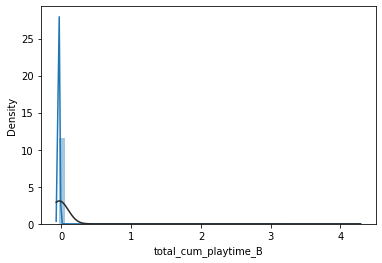

In [54]:
plt.figure()
sns.distplot(data['total_cum_playtime_B'],fit=norm)
plt.show()

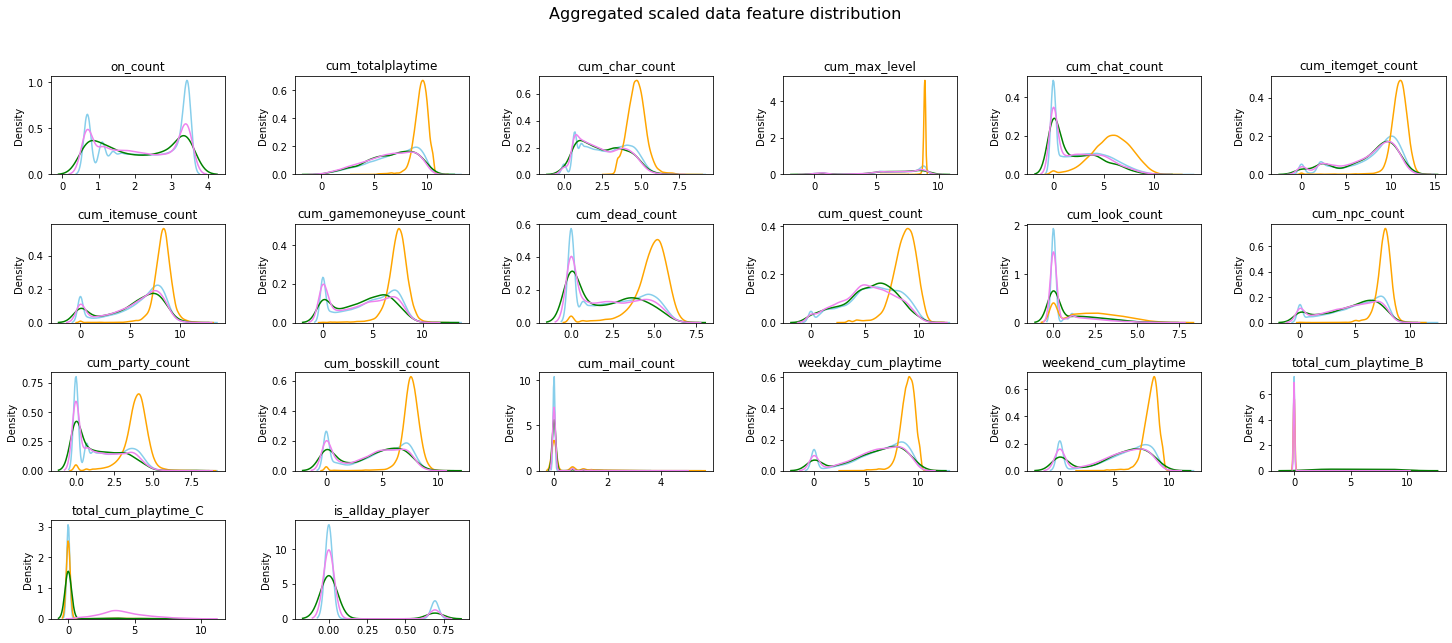

In [24]:
from scipy.stats import norm
import seaborn as sns

i = 1
plt.figure(figsize=(25, 12))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)
for col in data.columns:
    plt.subplot(5,6,i)
    sns.distplot(np.array(data[col]), hist=False, color='skyblue')#, label='total')
    sns.distplot(np.array(data[data['is_allday_player'] > 0.0][col]), kde=True, hist=False, color='orange')#, label='allday_player')
    sns.distplot(np.array(data[data['total_cum_playtime_B'] > .0][col]), color='green', kde=True, hist=False)#, label='game_B_player')
    sns.distplot(np.array(data[data['total_cum_playtime_C'] > .0][col]), color='violet', kde=True, hist=False)
    plt.title(str(col))
    i += 1

plt.suptitle("Aggregated scaled data feature distribution", fontsize= 16)
plt.show()

In [41]:
ssc = StandardScaler()
data = A.copy()
#data.iloc[:,:] =ssc.fit_transform(A)

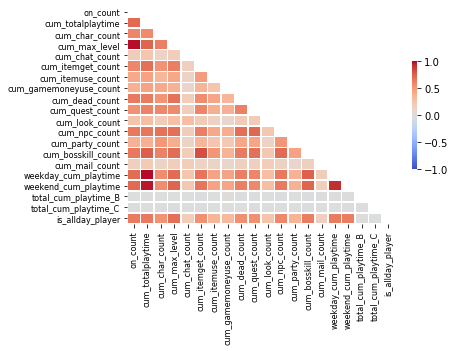

In [42]:
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
sns.heatmap(data.corr(), mask=mask, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [44]:
data['lookandchat'] = data['cum_chat_count'] + data['cum_look_count']
data['leveler'] = data['cum_max_level']/31.0 > 200
data['gamemoney_spender']

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,cum_look_count,cum_npc_count,cum_party_count,cum_bosskill_count,cum_mail_count,weekday_cum_playtime,weekend_cum_playtime,total_cum_playtime_B,total_cum_playtime_C,is_allday_player
f375e32231a2d3812d4fc648b5a53c4949c314d4eea9bd9206ed9a8c37d7a362,31.0,12165.0,145.0,7117.0,983.0,107237.0,15728.0,1256.0,88.0,3504.0,19.0,2174.0,43.0,2157.0,1.0,5725.0,6440.0,0.0,0.0,1.0
885eb058425f5266089d4a63e48dfeaa789b1d9628e97d8dad919e3eac8fc6a0,31.0,14471.0,128.0,6996.0,1131.0,71572.0,3084.0,7947.0,280.0,28724.0,4.0,2769.0,62.0,3212.0,1.0,7018.0,7453.0,0.0,0.0,1.0
7b98fcc7cf5d77600d28af060bcf3081451b540b1da8584adefb6dac14e6e3c9,2.0,105.0,3.0,257.0,74.0,20.0,21.0,20.0,1.0,46.0,0.0,47.0,1.0,2.0,0.0,105.0,0.0,0.0,0.0,0.0
a845622153bfea9f6aa32f163cbb05d83334bc6278fb2414c2bc8e39ae69e605,31.0,10750.0,114.0,7429.0,63.0,37286.0,2452.0,1119.0,107.0,7422.0,6.0,2787.0,44.0,1826.0,0.0,6858.0,3892.0,0.0,0.0,1.0
e01beef8c04539801032975c732ccf5ce437b288665090b8c5a8cf5abc6dfcc0,1.0,40.0,1.0,100.0,0.0,1385.0,126.0,0.0,0.0,2.0,0.0,1.0,0.0,8.0,0.0,40.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e7053168ba902d7e00ab5e5f79ce33df1a8bc7cd811f8fd53e7f417bb661b811,30.0,11487.0,88.0,6775.0,1577.0,109045.0,3946.0,8861.0,36.0,5659.0,7.0,2017.0,63.0,2753.0,0.0,7368.0,4119.0,0.0,0.0,0.0
2d782e8c7cb23a6f4bdcc1ca25dda74b997c724a891d51fb5b1346490e9d3617,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
29ae5ab1d2b2ed2c88cd85a1184844687e27e2b13dda4ab278fff6c4dee2ab38,5.0,1004.0,5.0,714.0,64.0,11690.0,894.0,93.0,6.0,447.0,0.0,205.0,2.0,203.0,0.0,207.0,797.0,0.0,0.0,0.0
ac1f3830343e08100eb8d553a02eca24b5e038e35f4b9f3ce44806b3613d394c,1.0,16.0,1.0,10.0,0.0,18.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0


In [50]:
data['cum_gamemoneyuse_count'].quantile(.99)

8199.859999999986

In [51]:
data['cum_gamemoneyuse_count'].quantile(1.0)

457862.0

In [111]:
ssc = StandardScaler()
data = A.copy()

#train_x = np.array(data.drop(['total_cum_playtime_B', 'total_cum_playtime_B'], axis=1))
train_x = np.array(data[['on_count', 'cum_totalplaytime', 'cum_gamemoneyuse_count', 'cum_quest_count', 'weekday_cum_playtime', 'weekend_cum_playtime']])
train_x = ssc.fit_transform(train_x)
train_y = []

for i in np.array(data['total_cum_playtime_B']):
    if i > 0:
        train_y.append(1)
    else:
        train_y.append(0)

In [113]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

#train_x = np.array(data[['on_count', 'cum_totalplaytime', 'cum_gamemoneyuse_count', 'cum_quest_count', 'weekday_cum_playtime', 'weekend_cum_playtime']])
#train_y = np.array(data['total_cum_playtime_B'])

sm = SMOTE()
ads = ADASYN()
ros = RandomOverSampler(random_state=0)
train_x, train_y = ads.fit_sample(train_x, train_y)

In [114]:
train_x.shape

(225433, 6)

In [115]:
Counter(train_y)

Counter({0: 112494, 1: 112939})

In [116]:
from sklearn import linear_model as lin
from sklearn.model_selection import cross_val_score

linReg = lin.LinearRegression()
ridge = lin.Ridge(alpha=.5)
lasso = lin.Lasso(alpha=0.1)
enet = lin.ElasticNet(random_state=0)
lassoLars = lin.LassoLars(alpha=.1)

cv_Ridge = lin.RidgeCV(alphas=np.logspace(-6, 6, 13))
cv_Lasso = lin.LassoCV()
cv_enet = lin.ElasticNetCV()

from sklearn.ensemble import RandomForestRegressor
rfReg = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)
reg_models = [cv_Ridge, cv_Lasso, cv_enet, lassoLars, rfReg]
reg_names = ['Ridge_CV', 
             'Lasso_CV', 
             'ElasticNet_CV',
             'Lasso Lars', 
             'Random Forest Regression']

K = 5
for model, name in zip(reg_models, reg_names):
    r2 = cross_val_score(model, train_x, train_y, scoring='r2', cv=K)
    MSE = cross_val_score(model, train_x, train_y, scoring='neg_mean_squared_error', cv=K)
    RMSE = cross_val_score(model, train_x, train_y, scoring='neg_root_mean_squared_error', cv=K)
    
    print("R-square: \t\t %0.4f (+/- %0.4f) [%s]" % (r2.mean(), r2.std(), name))
    print("MSE: \t\t\t %0.4f (+/- %0.4f)" % (MSE.mean(), MSE.std()))
    print("RMSE: \t\t\t %0.4f (+/- %0.4f)\n" % (RMSE.mean(), RMSE.std()))

R-square: 		 -19.0106 (+/- 23.3125) [Ridge_CV]
MSE: 			 -0.3559 (+/- 0.0544)
RMSE: 			 -0.5946 (+/- 0.0487)

R-square: 		 -19.0105 (+/- 23.3123) [Lasso_CV]
MSE: 			 -0.3561 (+/- 0.0545)
RMSE: 			 -0.5948 (+/- 0.0488)

R-square: 		 -19.0105 (+/- 23.3123) [ElasticNet_CV]
MSE: 			 -0.3561 (+/- 0.0545)
RMSE: 			 -0.5948 (+/- 0.0488)

R-square: 		 -19.2847 (+/- 23.6436) [Lasso Lars]
MSE: 			 -0.3607 (+/- 0.0553)
RMSE: 			 -0.5986 (+/- 0.0492)

R-square: 		 -0.8456 (+/- 1.3759) [Random Forest Regression]
MSE: 			 -0.1006 (+/- 0.0777)
RMSE: 			 -0.2913 (+/- 0.1253)



In [127]:
norm(data)

In [130]:
import tensorflow as tf
from tensorflow import keras
def build_model():
    
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=[train_x.shape[1]]),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model = build_model()

In [146]:
ssc = StandardScaler()
data = A.copy()

#train_x = np.array(data.drop(['total_cum_playtime_B', 'total_cum_playtime_B'], axis=1))
train_x = np.array(data[['on_count', 'cum_totalplaytime', 'cum_gamemoneyuse_count', 'cum_quest_count', 'weekday_cum_playtime', 'weekend_cum_playtime']])
train_x = ssc.fit_transform(train_x)
train_y = []

for i in np.array(data['total_cum_playtime_B']):
    if i > 0:
        train_y.append(1)
    else:
        train_y.append(0)

#sm = SMOTE()
ads = ADASYN()
#ros = RandomOverSampler(random_state=0)
train_x, train_y = ads.fit_sample(train_x, train_y)
        
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100

history = model.fit(
      train_x, np.array(train_y),
      epochs=EPOCHS, validation_split = 0.2, verbose=0,
      callbacks=[PrintDot()])


....................................................................................................

In [147]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,0.186269,0.383900,0.186269,0.324840,0.533510,0.324840,95
96,0.187282,0.384243,0.187282,0.362318,0.571703,0.362318,96
97,0.186198,0.383669,0.186198,0.370683,0.576364,0.370683,97
98,0.187030,0.383714,0.187030,0.335638,0.546943,0.335638,98
99,0.187002,0.383485,0.187002,0.391591,0.599519,0.391591,99


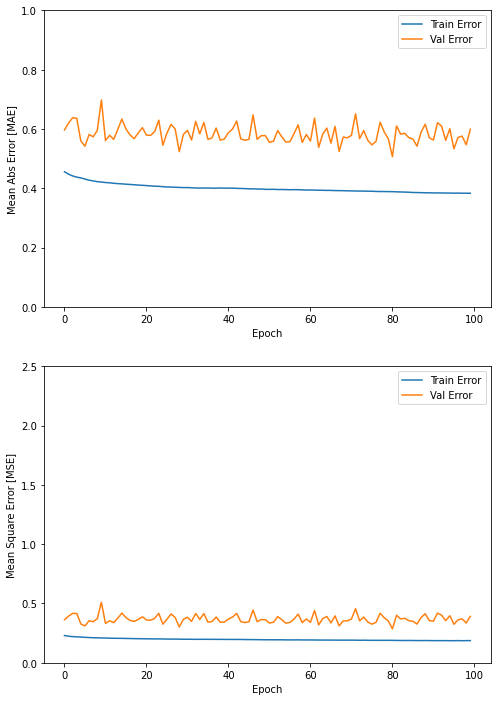

In [150]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MSE]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,2.5])
    plt.legend()
    plt.show()

plot_history(history)


In [149]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [158]:
128*10

1280

In [167]:
64*2

128

Epoch 1/1000
1409/1409 [==============================] - 6s 4ms/step - loss: 0.2449 - val_loss: 0.3790
Epoch 2/1000
1409/1409 [==============================] - 6s 4ms/step - loss: 0.2288 - val_loss: 0.3833
Epoch 3/1000
1409/1409 [==============================] - 5s 4ms/step - loss: 0.2261 - val_loss: 0.3734
Epoch 4/1000
1409/1409 [==============================] - 6s 4ms/step - loss: 0.2219 - val_loss: 0.3661
Epoch 5/1000
1409/1409 [==============================] - 6s 4ms/step - loss: 0.2205 - val_loss: 0.3508
Epoch 6/1000
1409/1409 [==============================] - 6s 4ms/step - loss: 0.2170 - val_loss: 0.3932
Epoch 7/1000
1409/1409 [==============================] - 6s 4ms/step - loss: 0.2143 - val_loss: 0.3775
Epoch 8/1000
1409/1409 [==============================] - 6s 4ms/step - loss: 0.2122 - val_loss: 0.3771
Epoch 9/1000
1409/1409 [==============================] - 6s 4ms/step - loss: 0.2098 - val_loss: 0.3634
Epoch 10/1000
1409/1409 [==============================] - 6s 4m

<AxesSubplot:>

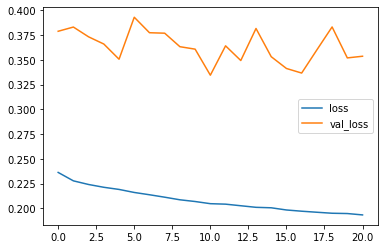

In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(1280,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(576,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(320,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(192,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
    
model.compile(optimizer='adam', loss='mse')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=train_x,
                  y=np.array(train_y),
                  validation_split = 0.2,
                  batch_size=128,
                  epochs=1000,
                  callbacks=[early_stop])

losses = pd.DataFrame(history.history)
losses.plot()

In [177]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
predictions = model.predict(X_test)
mean_absolute_error(y_test,predictions)
np.sqrt(mean_squared_error(y_test,predictions))

NameError: name 'X_test' is not defined

In [178]:
rfReg = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)
reg_models = [model, rfReg]
reg_names = ['DNN', 
             'Random Forest Regression']

K = 5
for mod, name in zip(reg_models, reg_names):
    r2 = cross_val_score(mod, train_x, train_y, scoring='r2', cv=K)
    MSE = cross_val_score(mod, train_x, train_y, scoring='neg_mean_squared_error', cv=K)
    RMSE = cross_val_score(mod, train_x, train_y, scoring='neg_root_mean_squared_error', cv=K)
    
    print("R-square: \t\t %0.4f (+/- %0.4f) [%s]" % (r2.mean(), r2.std(), name))
    print("MSE: \t\t\t %0.4f (+/- %0.4f)" % (MSE.mean(), MSE.std()))
    print("RMSE: \t\t\t %0.4f (+/- %0.4f)\n" % (RMSE.mean(), RMSE.std()))

TypeError: Cannot clone object '<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000021EE45103C8>' (type <class 'tensorflow.python.keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [74]:
def CNNfnet_model(INPUT_LIST, learning_rate 0.01):
    
    input_length = INPUT_LIST[0].shape[1]
    
    ## CNN model define
    optim keras.optimizers.SGD(lr learning_rate)
    # model for in sample time series data
    MODEL Sequential()
    MODEL.add(Conv1D( 128 , 8 , input_shape (input_length, 1
    MODEL.add(BatchNormalization())
    MODEL.add(Acti vation(vation('
    MODEL.add(Conv1D( 256 , 5
    MODEL.add(BatchNormalization())
    MODEL.add(Activation( Activation('
    MODEL.add(Conv1D( 128 , 3
    MODEL.add(BatchNormalization())
    MODEL.add(Activation( Activation('
    MODEL.add(GlobalAveragePooling1D())
    MODEL.add(Dense( 1 , activation =='
    MODEL. compile (optimizer optim, loss 'mean_squared_ error', metrics [['
    return MODEL

array([[ 1.4544891 ,  1.08683645,  1.30177306, ...,  1.92212556,
        -0.07872967,  2.28621108],
       [ 1.4544891 ,  1.41621699,  1.08511483, ...,  2.32896953,
        -0.07872967,  2.28621108],
       [-1.00468479, -0.63576949, -0.5079604 , ..., -0.66432571,
        -0.07872967, -0.43740493],
       ...,
       [-0.75028749, -0.50735964, -0.48247119, ..., -0.34423229,
        -0.07872967, -0.43740493],
       [-1.08948389, -0.64848192, -0.5334496 , ..., -0.66432571,
        -0.07872967, -0.43740493],
       [ 1.4544891 ,  1.94071193,  2.11742757, ...,  1.86188213,
        -0.07872967,  2.28621108]])

In [61]:
train_x.shape

(113408, 19)

In [62]:
train_y.shape

(113408,)

In [63]:
data

,on_count,cum_totalplaytime,cum_char_count,cum_max_level,cum_chat_count,cum_itemget_count,cum_itemuse_count,cum_gamemoneyuse_count,cum_dead_count,cum_quest_count,cum_look_count,cum_npc_count,cum_party_count,cum_bosskill_count,cum_mail_count,weekday_cum_playtime,weekend_cum_playtime,total_cum_playtime_B,total_cum_playtime_C,is_allday_player
f375e32231a2d3812d4fc648b5a53c4949c314d4eea9bd9206ed9a8c37d7a362,0.897919,0.735649,0.833680,0.942272,0.198418,1.070518,1.408574,0.127807,0.298901,0.190065,0.173462,0.744640,0.332746,0.815513,0.312008,0.474813,1.072311,-0.037137,-0.082002,1.189735
885eb058425f5266089d4a63e48dfeaa789b1d9628e97d8dad919e3eac8fc6a0,0.897919,0.882203,0.734824,0.925148,0.242348,0.738796,0.230164,1.286207,1.214034,1.782007,-0.139706,0.944595,0.535915,1.147940,0.312008,0.634487,1.202663,-0.037137,-0.082002,1.189735
7b98fcc7cf5d77600d28af060bcf3081451b540b1da8584adefb6dac14e6e3c9,NaN,-1.009968,-0.709196,-2.343304,-0.124308,-0.817961,-0.557004,-0.389029,-0.835476,-0.579019,-0.242921,-0.822094,-0.356379,-0.821900,-0.131338,-0.921523,-1.091614,-0.037137,-0.082002,-0.575195
a845622153bfea9f6aa32f163cbb05d83334bc6278fb2414c2bc8e39ae69e605,0.897919,0.633781,0.645369,0.985120,-0.128928,0.263728,0.110902,0.082040,0.437054,0.665019,-0.091836,0.950063,0.344533,0.683438,-0.131338,0.616056,0.641217,-0.037137,-0.082002,1.189735
e01beef8c04539801032975c732ccf5ce437b288665090b8c5a8cf5abc6dfcc0,NaN,-1.035789,-0.762389,-3.231822,-0.155806,-0.748983,-0.516785,-0.400039,-0.860019,-0.593861,-0.242921,-0.907637,-0.380281,-0.810435,-0.131338,-0.957320,-1.091614,-0.037137,-0.082002,-0.575195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e7053168ba902d7e00ab5e5f79ce33df1a8bc7cd811f8fd53e7f417bb661b811,0.862759,0.688131,0.454465,0.893094,0.364139,1.084729,0.372825,1.375783,-0.221078,0.478534,-0.068735,0.684459,0.545545,1.016639,-0.131338,0.673657,0.688114,-0.037137,-0.082002,-0.575195
2d782e8c7cb23a6f4bdcc1ca25dda74b997c724a891d51fb5b1346490e9d3617,NaN,-1.051199,-0.790086,-5.659965,-0.155806,-0.819008,-0.565246,-0.400039,-0.860019,-0.594540,-0.242921,-0.909580,-0.380281,-0.825752,-0.131338,-0.978858,-1.091614,-0.037137,-0.082002,-0.575195
29ae5ab1d2b2ed2c88cd85a1184844687e27e2b13dda4ab278fff6c4dee2ab38,-1.387445,-0.707976,-0.658690,-1.344988,-0.128507,-0.341389,-0.263432,-0.349839,-0.721058,-0.453038,-0.242921,-0.573981,-0.333035,-0.495250,-0.131338,-0.867811,-0.421949,-0.037137,-0.082002,-0.575195
ac1f3830343e08100eb8d553a02eca24b5e038e35f4b9f3ce44806b3613d394c,NaN,-1.045494,-0.762389,-4.950069,-0.155806,-0.818066,-0.565246,-0.400039,-0.860019,-0.592842,-0.242921,-0.909580,-0.380281,-0.825752,-0.131338,-0.970869,-1.091614,-0.037137,-0.082002,-0.575195


In [ ]:
class MLPModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            weight_norm(nn.Linear(num_features, 128)),
            nn.ReLU(),
            weight_norm(nn.Linear(128, 128)),
            nn.ReLU(),
            weight_norm(nn.Linear(128, 128)),
            nn.ReLU(),
            weight_norm(nn.Linear(128, 128)),
            nn.ReLU(),
            weight_norm(nn.Linear(128, 1)),
        )
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight_v)
                nn.init.kaiming_normal_(m.weight_g)
                nn.init.constant_(m.bias, 0)

    def forward(self, input_tensor):
        return torch.clamp(self.model(input_tensor), 0, 1)


def get_model(num_features):
    return MLPModel(num_features).to(DEVICE)

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self, attribute_dim, latent_dim):
        super(Autoencoder, self).__init__();
        self.encoder = nn.Linear(attribute_dim, latent_dim);
        self.decoder = nn.Linear(latent_dim, attribute_dim);
        self.attr = attribute_dim

    def forward(self, x, batch_size):
        x = x.view(batch_size, -1);
        encoded = self.encoder(x)
        out = self.decoder(encoded)  # .view(batch_size,1,self.attr)
        return out

    def encode(self, x):
        x = x.view(len(x), -1);
        encoded = self.encoder(x);
        return encoded
    
raw_data = data.copy()
learning_rate = 0.05
batch_size = 256
num_epoch = 200

train = data.copy()
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(train, batch_size=len(train), shuffle=False, drop_last=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_ae = Autoencoder(data.shape[1], self.params['dim']).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_ae.parameters(), lr=learning_rate)
loss_arr = []
time.sleep(1e-1)
pbar = tqdm(range(num_epoch), desc='auto-encoder training', position=0, leave=True)

for epochs in range(num_epoch):
    total_loss = 0
    for i in train_loader:
        x = i.to(device).float()
        optimizer.zero_grad()
        output = model_ae.forward(x, batch_size)
        loss = loss_func(output, x)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    loss_arr.append(total_loss)
    pbar.update(1)
pbar.close()

for j in test_loader:
    x = j.to(device).float()
    output = model_ae.forward(x, len(train))
    loss = loss_func(output, x)
print('Training MSE loss :: %s' % (loss.item()))

In [ ]:
model_ae.encode(torch.tensor(train).float().to(device)).cpu().detach().numpy()

In [ ]:
#[4] usertype_4: 파티 선호 유저 >>> 'party_count'가 높은 유저 - 파티 위주의 게임을 선호할 가능성 높음
#[5] usertype_5: 숙제만 하고 있는 유저 >>> daily 'totalplaytime'이 낮으면서 'quest_count'가 일정한 유저: 게임 머니 얻을 목적으로 귀찮지만 매일매일 접속해서 퀘스트만 깨고 게임 종료하는 유저
# * 생략 * [6] usertype_6: 하드코어 선호 유저 >>> 'max_level'이 낮으면서 'dead_count'가 높은 유저 ⭐️⭐️⭐️ 전반적인 게임 특성인지도 파악해보기 !!! ⭐️⭐️⭐️

In [ ]:
매일 접속자인 사람들 중에 
- max_level 차이가 많이 나는 사람?
- max_level은 낮은데 


Index(['sdate', 'totalplaytime', 'max_level', 'char_count', 'chat_count',
       'itemget_count', 'itemuse_count', 'gamemoneyuse_count', 'dead_count',
       'quest_count', 'look_count', 'npc_count', 'party_count',
       'dungeon_count', 'mail_count', 'id'],
      dtype='object')

In [142]:
game_A.columns

Index(['sdate', 'totalplaytime', 'char_count', 'max_level', 'chat_count',
       'itemget_count', 'itemuse_count', 'gamemoneyuse_count', 'dead_count',
       'quest_count', 'look_count', 'npc_count', 'party_count',
       'bosskill_count', 'mail_count', 'id'],
      dtype='object')

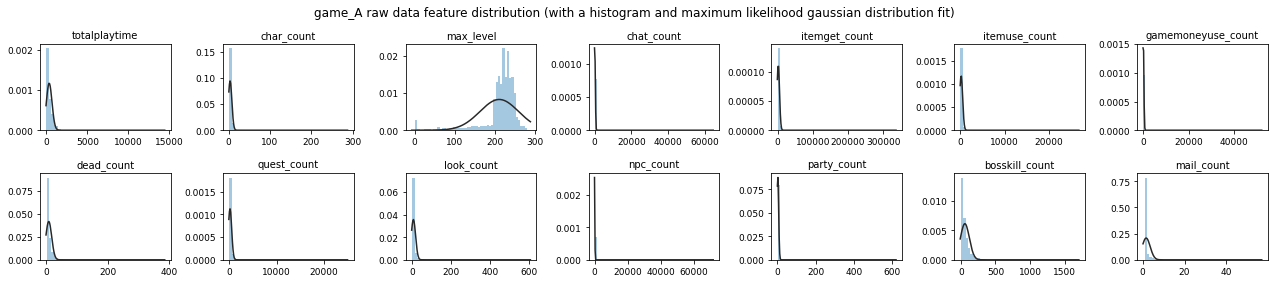

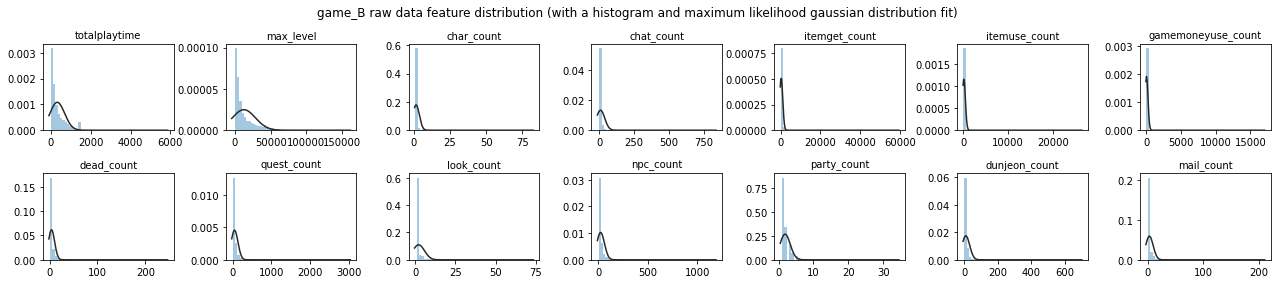

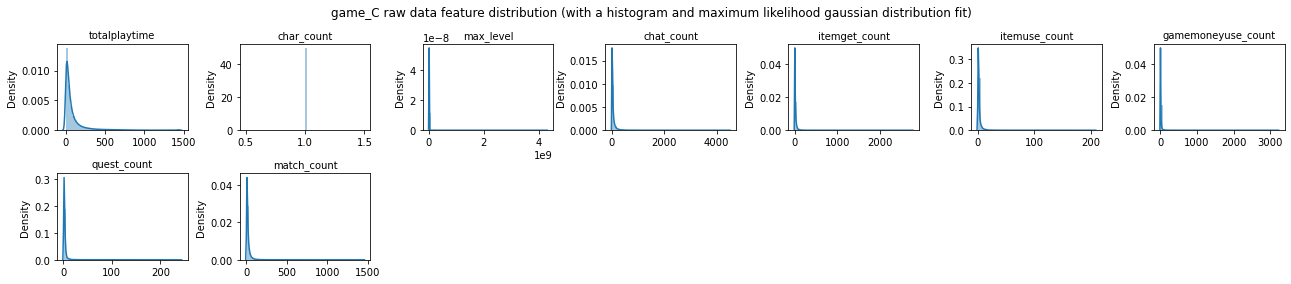

In [28]:
from scipy.stats import norm
import seaborn as sns

i = 1
plt.figure(figsize=(22, 4))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.5)

for col in game_A.columns[1:-1]:
    plt.subplot(2,7,i)
    sns.distplot(np.array(game_A[col]), fit=norm, kde=False)
    plt.title(str(col), fontsize=10)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    i += 1
    
plt.suptitle("game_A raw data feature distribution (with a histogram and maximum likelihood gaussian distribution fit)", fontsize= 12)
#plt.savefig(os.path.join(data_dir, 'game_A raw data feature distribution.png'))
plt.show()

i = 1
plt.figure(figsize=(22, 4))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.5)

for col in game_B.columns[1:-1]:
    plt.subplot(2,7,i)
    sns.distplot(np.array(game_B[col]), fit=norm, kde=False)
    plt.title(str(col), fontsize=10)
    i += 1
    
plt.suptitle("game_B raw data feature distribution (with a histogram and maximum likelihood gaussian distribution fit)", fontsize= 12)
#plt.savefig(os.path.join(data_dir, 'game_B raw data feature distribution.png'))
plt.show()

i = 1
plt.figure(figsize=(22, 4))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.85, wspace=0.4, hspace=0.5)

for col in game_C.columns[1:-1]:
    plt.subplot(2,7,i)
    sns.distplot(np.array(game_C[col]))
    plt.title(str(col), fontsize=10)
    i += 1
    
plt.suptitle("game_C raw data feature distribution (with a histogram and maximum likelihood gaussian distribution fit)", fontsize= 12)
#plt.savefig(os.path.join(data_dir, 'game_B raw data feature distribution.png'))
plt.show()

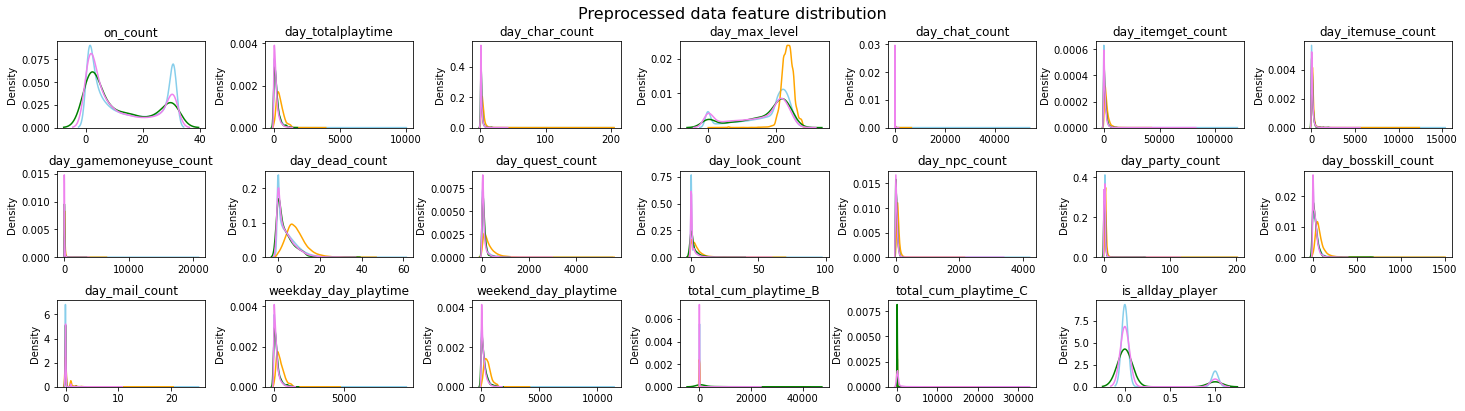

In [29]:
from scipy.stats import norm
import seaborn as sns

i = 1
plt.figure(figsize=(25, 6))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)

for col in A.columns:
    plt.subplot(3,7,i)
    sns.distplot(np.array(A[col]), hist=False, color='skyblue')#, label='total')
    sns.distplot(np.array(A[A['is_allday_player'] == 1.0][col]), kde=True, hist=False, color='orange')#, label='allday_player')
    sns.distplot(np.array(A[A['total_cum_playtime_B'] > .0][col]), color='green', kde=True, hist=False)#, label='game_B_player')
    sns.distplot(np.array(A[A['total_cum_playtime_C'] > .0][col]), color='violet', kde=True, hist=False)
    plt.title(str(col))
    i += 1

plt.suptitle("Preprocessed data feature distribution", fontsize= 16)
plt.show()

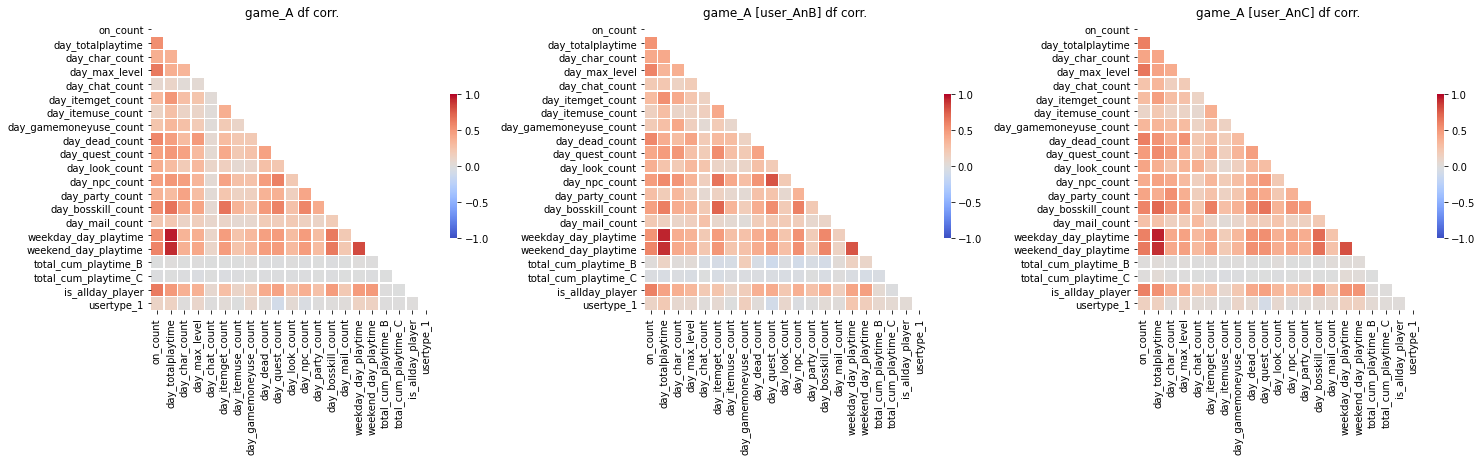

In [92]:
import seaborn as sns
plt.figure(figsize=(24,5))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)

plt.subplot(1,3,1)
mask = np.triu(np.ones_like(A.corr(), dtype=bool))
sns.heatmap(A.corr(), mask=mask, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_A df corr.")

plt.subplot(1,3,2)
mask = np.triu(np.ones_like(A.loc[user_AnB].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnB].corr(), mask=mask, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_A [user_AnB] df corr.")

plt.subplot(1,3,3)
mask = np.triu(np.ones_like(A.loc[user_AnC].corr(), dtype=bool))
sns.heatmap(A.loc[user_AnC].corr(), mask=mask, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_A [user_AnC] df corr.")
plt.show()

In [44]:
i=0
print("Features related to 'total_cum_playtime_B':")
for col in A.columns:
    if abs(A.loc[user_AnB].corr()['total_cum_playtime_B'][i]) >= .10:
        if col != 'total_cum_playtime_B':
            print("\t-",col)
    i+=1
i=0
print("Features related to 'total_cum_playtime_C':")
for col in A.columns:
    if abs(A.loc[user_AnC].corr()['total_cum_playtime_C'][i]) >= .10:
        if col != 'total_cum_playtime_C':
            print("\t-",col)
    i+=1
    
print('\ngame_B User: \n\tgame_A에서 게임재화 많이 사용하면서, 평일이나 주말이나 항상 많이 게임하고, 누적 플레이시간도 길고, quest는 많이 완료하지 않는 유저.')

Features related to 'total_cum_playtime_B':
	- day_totalplaytime
	- day_gamemoneyuse_count
	- day_quest_count
	- weekday_day_playtime
	- weekend_day_playtime
Features related to 'total_cum_playtime_C':

game_B User: 
	game_A에서 게임재화 많이 사용하면서, 평일이나 주말이나 항상 많이 게임하고, 누적 플레이시간도 길고, quest는 많이 완료하지 않는 유저.


In [49]:
sc = MinMaxScaler()
T = A.copy()
T.iloc[:,:] = sc.fit_transform(A)
T

,on_count,day_totalplaytime,day_char_count,day_max_level,day_chat_count,day_itemget_count,day_itemuse_count,day_gamemoneyuse_count,day_dead_count,day_quest_count,day_look_count,day_npc_count,day_party_count,day_bosskill_count,day_mail_count,weekday_day_playtime,weekend_day_playtime,total_cum_playtime_B,total_cum_playtime_C,is_allday_player
d48cc1aa2f1a6208b13b175af4de37fbcfeba90a8b5a93605f7d2134a3d681f4,0.533333,0.013622,0.008110,0.757995,0.000063,0.003919,0.002649,0.001967,0.092593,0.004704,0.000000,0.006616,0.007279,0.022173,0.0,0.012416,0.014329,0.0,0.000000,0.0
b3c59a7532a461aebc2c32cce80b9b4dfb210db2911faa2f2f81df4780fdaf40,1.000000,0.029165,0.046861,0.805153,0.003893,0.011344,0.007190,0.012914,0.177451,0.042259,0.025257,0.021930,0.009055,0.042709,0.0,0.024465,0.036760,0.0,0.000000,1.0
b2d5dcb1aefe85294feb3604b99d60d306603939ffcd2017e728c4a442cc1bad,0.166667,0.027575,0.011489,0.443147,0.000517,0.020975,0.093960,0.003604,0.083333,0.033642,0.000000,0.022915,0.015012,0.029181,0.0,0.035983,0.012978,0.0,0.000000,0.0
59434bcc026b70a05d6f4c6e80d0ae504e047a58c8cd8967e953b2d446742c22,0.166667,0.006722,0.004924,0.722414,0.000201,0.001119,0.002880,0.003379,0.050000,0.006407,0.000000,0.007426,0.006255,0.008675,0.0,0.007462,0.004487,0.0,0.000000,0.0
8e9d5dca1ce8ce4faebc5d47129f1ac67e9a3b4e54bc41dea918120776b16d1b,0.066667,0.057257,0.011489,0.723847,0.000223,0.039859,0.031771,0.004052,0.075000,0.034007,0.000000,0.023749,0.010008,0.050700,0.0,0.064260,0.044257,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e167714af0f10793acbfbfd2515cd748d7dd73b3c9cb12b9d7f51b35231a0399,0.000000,0.000301,0.004924,0.799098,0.000000,0.000059,0.000000,0.000048,0.000000,0.000547,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000264,0.0,0.000000,0.0
fc344e94a2aaeeefd470ed66383eb28c80bbcb2872882588c8620fbc0193c580,0.266667,0.018495,0.008206,0.788348,0.000037,0.084401,0.019180,0.002605,0.000000,0.003123,0.000000,0.008054,0.007506,0.041912,0.0,0.024095,0.014356,0.0,0.000000,0.0
b58b3ada55e333bcc39f8423b0ea89dd0b7cc4d0fbcba5f5703d5af9e23e4e66,0.166667,0.005067,0.016413,0.616942,0.000000,0.001041,0.000671,0.000000,0.016667,0.002763,0.026000,0.001112,0.005004,0.003380,0.0,0.006086,0.003255,0.0,0.000000,0.0
b511bd8bbb37beb69a2e1d37f464f14a9b1434d73cac16aefc16400f3719ace4,1.000000,0.026951,0.013818,0.762340,0.000109,0.012105,0.006362,0.003844,0.102564,0.053590,0.020800,0.017671,0.007599,0.040408,0.0,0.029122,0.022647,0.0,0.000000,1.0


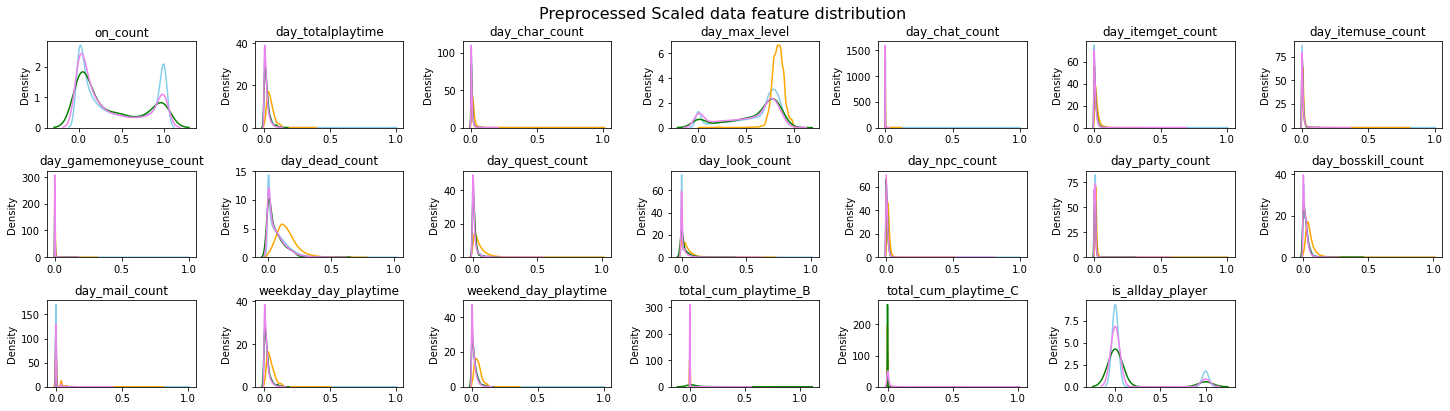

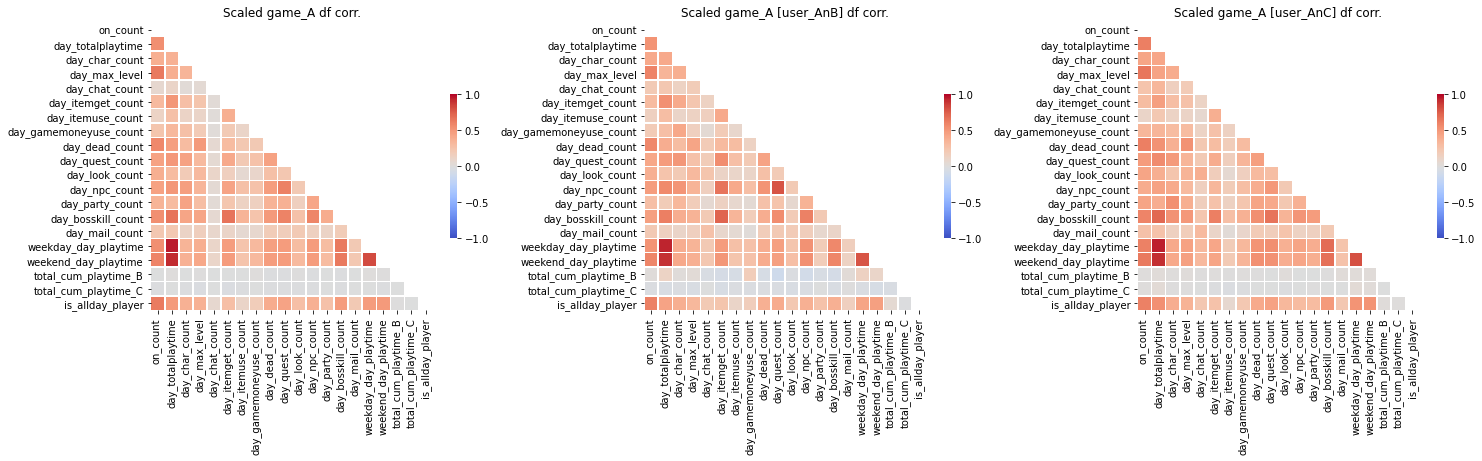

Features related to 'total_cum_playtime_B':
	- day_totalplaytime
	- day_gamemoneyuse_count
	- day_quest_count
	- weekday_day_playtime
	- weekend_day_playtime
Features related to 'total_cum_playtime_C':


In [66]:
from scipy.stats import norm
import seaborn as sns

i = 1
plt.figure(figsize=(25, 6))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)

for col in T.columns:
    plt.subplot(3,7,i)
    sns.distplot(np.array(T[col]), hist=False, color='skyblue')#, label='total')
    sns.distplot(np.array(T[T['is_allday_player'] == 1.0][col]), kde=True, hist=False, color='orange')#, label='allday_player')
    sns.distplot(np.array(T[T['total_cum_playtime_B'] > .0][col]), color='green', kde=True, hist=False)#, label='game_B_player')
    sns.distplot(np.array(T[T['total_cum_playtime_C'] > .0][col]), color='violet', kde=True, hist=False)
    plt.title(str(col))
    i += 1

plt.suptitle("Preprocessed Scaled data feature distribution", fontsize= 16)
plt.show()


import seaborn as sns
plt.figure(figsize=(24,5))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.5)

plt.subplot(1,3,1)
mask = np.triu(np.ones_like(T.corr(), dtype=bool))
sns.heatmap(T.corr(), mask=mask, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("Scaled game_A df corr.")

plt.subplot(1,3,2)
mask = np.triu(np.ones_like(T.loc[user_AnB].corr(), dtype=bool))
sns.heatmap(T.loc[user_AnB].corr(), mask=mask, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("Scaled game_A [user_AnB] df corr.")

plt.subplot(1,3,3)
mask = np.triu(np.ones_like(T.loc[user_AnC].corr(), dtype=bool))
sns.heatmap(T.loc[user_AnC].corr(), mask=mask, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("Scaled game_A [user_AnC] df corr.")
plt.show()

i=0
related_columns = []
print("Features related to 'total_cum_playtime_B':")
for col in T.columns:
    if abs(T.loc[user_AnB].corr()['total_cum_playtime_B'][i]) >= .10:
        if col != 'total_cum_playtime_B':
            print("\t-",col)
            related_columns.append(col)
    i+=1
i=0
print("Features related to 'total_cum_playtime_C':")
for col in T.columns:
    if abs(T.loc[user_AnC].corr()['total_cum_playtime_C'][i]) >= .10:
        if col != 'total_cum_playtime_C':
            print("\t-",col)
    i+=1

In [70]:
T.loc[user_AnC].corr()['total_cum_playtime_C']

on_count                  0.012838
day_totalplaytime         0.044235
day_char_count            0.007661
day_max_level             0.002071
day_chat_count           -0.007110
day_itemget_count        -0.013138
day_itemuse_count        -0.018016
day_gamemoneyuse_count   -0.008754
day_dead_count           -0.003897
day_quest_count          -0.002561
day_look_count           -0.011006
day_npc_count            -0.001986
day_party_count           0.003132
day_bosskill_count       -0.002492
day_mail_count           -0.006205
weekday_day_playtime      0.046452
weekend_day_playtime      0.028445
total_cum_playtime_B     -0.003650
total_cum_playtime_C      1.000000
is_allday_player          0.014024
Name: total_cum_playtime_C, dtype: float64

In [91]:
#[1] usertype_1: 친목활동을 좋아하는 유저 >>> 'look_count', 'chat_count'가 높은 유저 
#[2] usertype_2: 렙업 해서 강해지는 거에 재미를 느끼는 유저 >>> 'max_level', 'itemget_count', 'itemuse_count', 'quest_count'가 높은 유저
#[3] usertype_3: 퀘스트, 스토리 위주로 즐기는 유저 >>> 'quest_count', 'npc_count'가 높은 유저 

print(related_columns)
id_set = set(A.index)
for col in related_columns:
    if col == 'day_quest_count':
        val = A[col].quantile(.5)
        data = A[A[col] < val]
        id_set = id_set & set(data.index)
        print(id_set)
    else:
        val = A[col].quantile(.5)
        data = A[A[col] >= val]
        id_set = id_set & set(data.index)
        print(id_set)
        
for _id in tqdm(user_A):
    if _id in id_set:
        A.loc[_id, 'usertype_1'] = 1
    else:
        A.loc[_id, 'usertype_1'] = 0

  0%|                                                                                       | 0/113408 [00:00<?, ?it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████| 113408/113408 [00:06<00:00, 16480.01it/s]


In [90]:
(A['usertype_1'] == 1.0).sum()

4458

In [75]:
id_set

set()

In [66]:
game_A = pd.read_csv(os.path.join(data_dir, 'game_A.csv'))
game_A['sdate'] = pd.to_datetime(game_A['sdate'])
game_A = game_A.sort_values(by='sdate', ascending=True)

game_B = pd.read_csv(os.path.join(data_dir, 'game_B.csv'))
game_B['sdate'] = pd.to_datetime(game_B['sdate'])
game_B = game_B.sort_values(by='sdate', ascending=True)

game_A.index = game_A.id
game_A.loc[user_AnB, "game_AB_player"] = 1
game_A = game_A.replace(np.nan, 0)
game_A = game_A.drop(['id'], axis=1)

game_B.index = game_B.id
game_B.loc[user_AnB, "game_AB_player"] = 1
game_B = game_B.replace(np.nan, 0)
game_B = game_B.drop(['id'], axis=1)

In [71]:
set(game_B["game_AB_player"])

{0.0, 1.0}

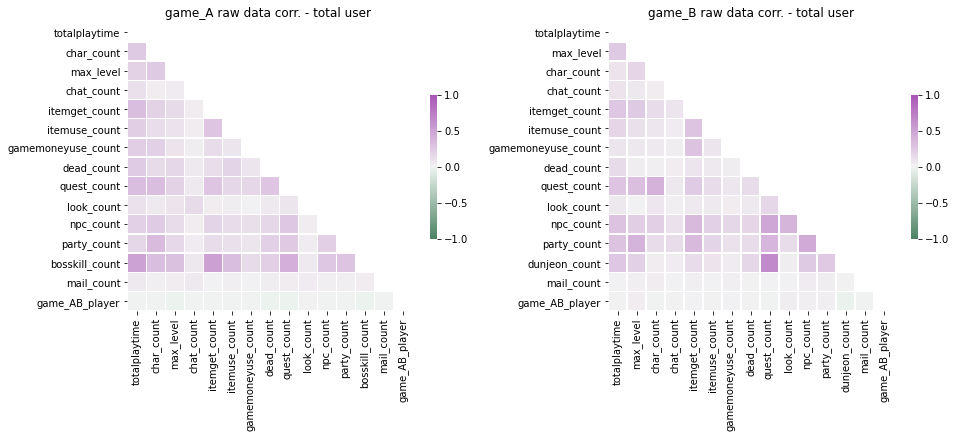

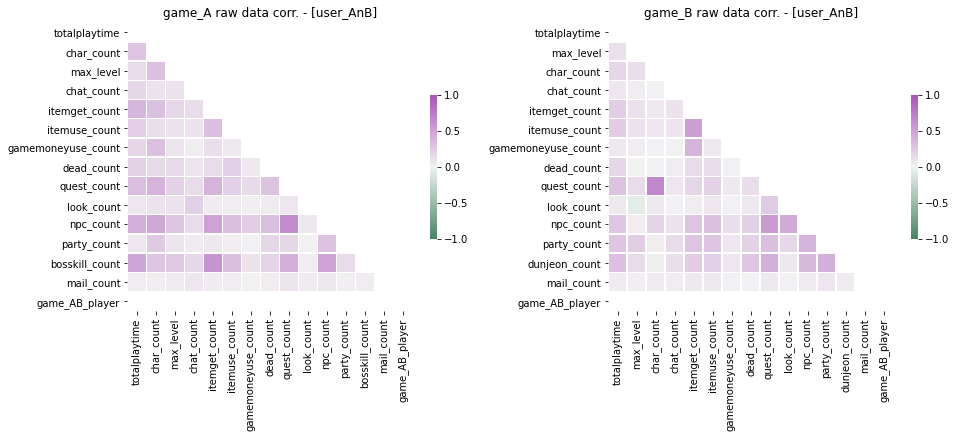

In [70]:
plt.figure(figsize=(15,5))
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

plt.subplot(1,2,1)
mask = np.triu(np.ones_like(game_A.corr(), dtype=bool))
sns.heatmap(game_A.corr(), mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_A raw data corr. - total user ")

plt.subplot(1,2,2)
mask = np.triu(np.ones_like(game_B.corr(), dtype=bool))
sns.heatmap(game_B.corr(), mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_B raw data corr. - total user")
plt.savefig(os.path.join(data_dir, 'raw_data_corr_mat.png'))
plt.show()

plt.figure(figsize=(15,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

plt.subplot(1,2,1)
mask = np.triu(np.ones_like(game_A.loc[user_AnB].corr(), dtype=bool))
sns.heatmap(game_A.loc[user_AnB].corr(), mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_A raw data corr. - [user_AnB]")

plt.subplot(1,2,2)
mask = np.triu(np.ones_like(game_B.loc[user_AnB].corr(), dtype=bool))
sns.heatmap(game_B.loc[user_AnB].corr(), mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_B raw data corr. - [user_AnB]")
plt.savefig(os.path.join(data_dir, 'raw_data_AnB_corr_mat.png'))
plt.show()

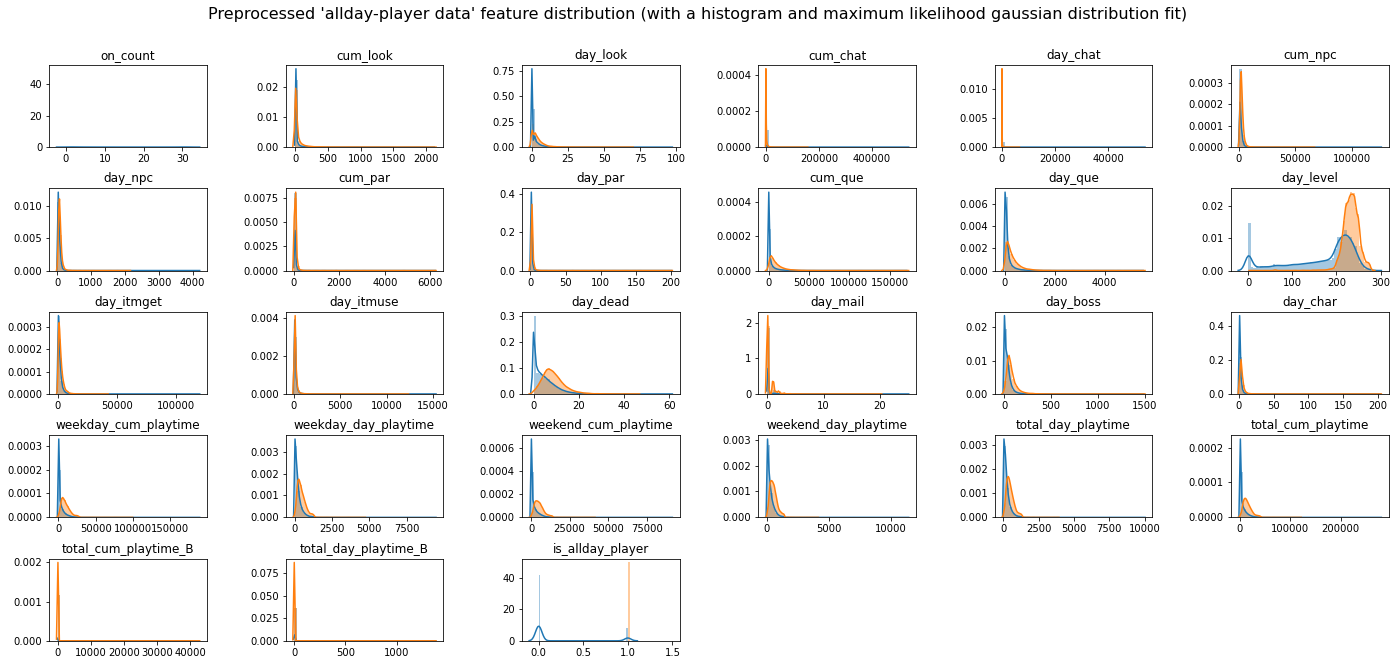

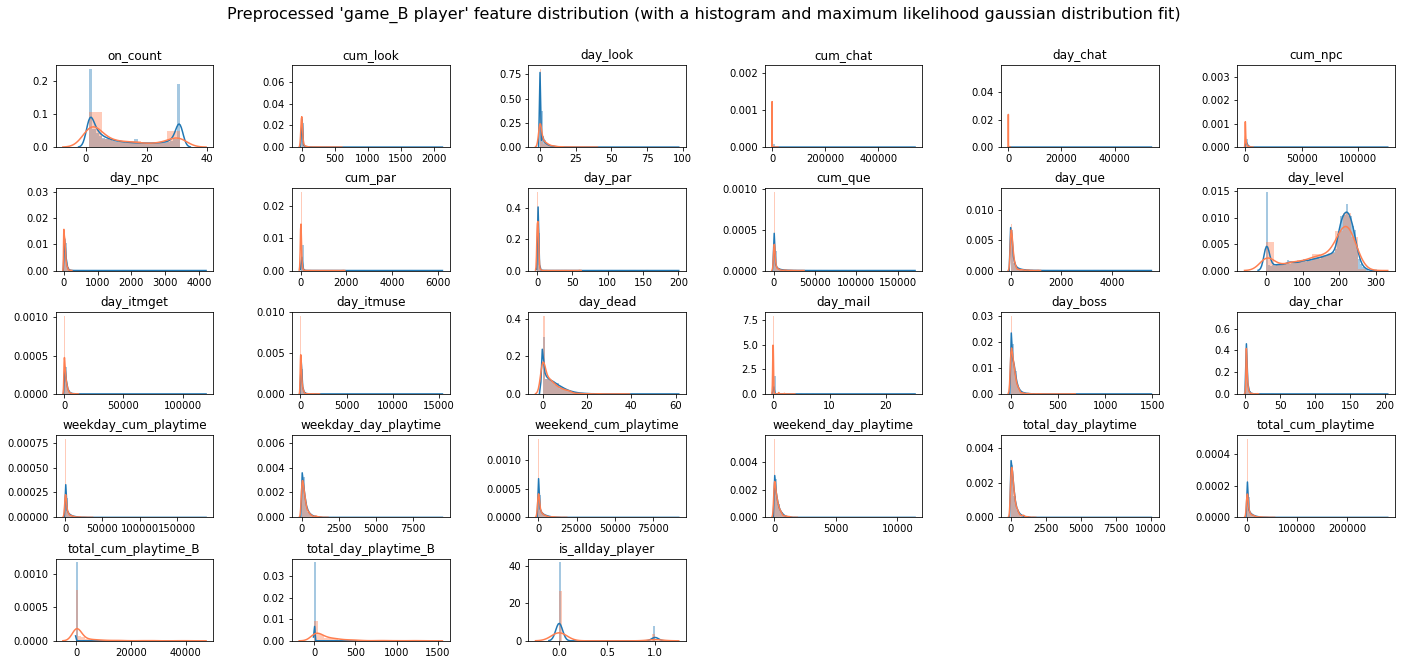

In [206]:
i = 1
plt.figure(figsize=(24, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

for col in A.columns:
    if (col == 'day_dung'):
        pass
    else:
        plt.subplot(5,6,i)
        sns.distplot(np.array(A[col]))
        sns.distplot(np.array(A[A['is_allday_player'] == 1.0][col]))
        plt.title(str(col))
        i += 1

plt.suptitle("Preprocessed 'allday-player data' feature distribution (with a histogram and maximum likelihood gaussian distribution fit)", fontsize= 16)
plt.show()


i = 1
plt.figure(figsize=(24, 10))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

for col in A.columns:
    if (col == 'day_dung'):
        pass
    else:
        plt.subplot(5,6,i)
        sns.distplot(np.array(A[col]))
        sns.distplot(np.array(A[A['total_cum_playtime_B'] > .0][col]), color='coral')
        plt.title(str(col))
        i += 1

plt.suptitle("Preprocessed 'game_B player' feature distribution (with a histogram and maximum likelihood gaussian distribution fit)", fontsize= 16)
plt.show()

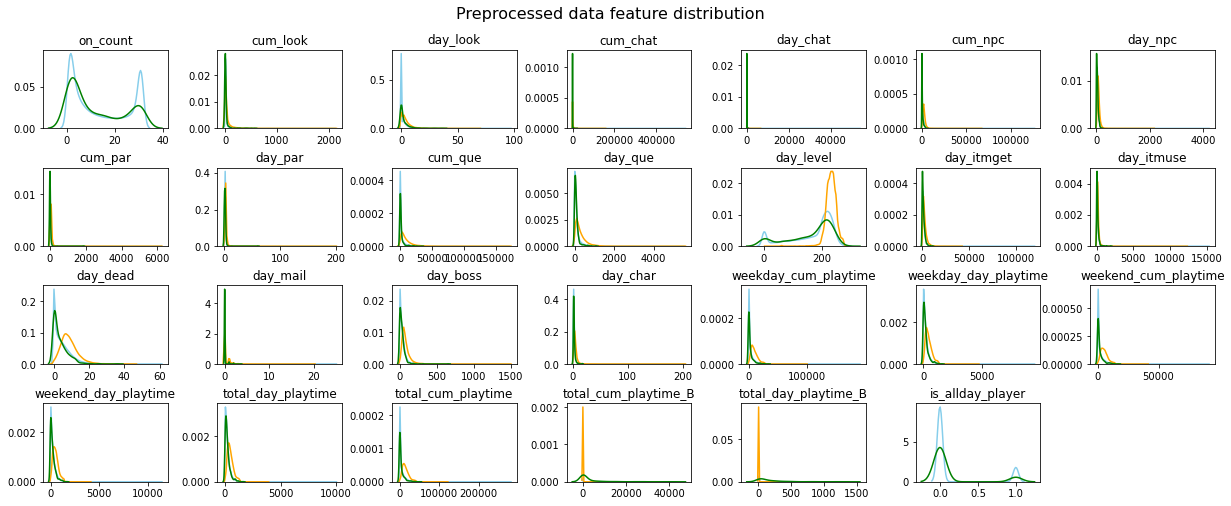

In [207]:
A.to_csv(os.path.join(data_dir, 'A.csv'), header=True, index=True)

In [209]:
set(A['is_allday_player'])

{0.0, 1.0}

In [ ]:
fig = plt.figure()
axes = fig.subplots(nrows=2, ncols=2)


for ax in fig.axes:
    ax.plot([0, 10], [0, 10], label='linear')

lines, labels = fig.axes[-1].get_legend_handles_labels()
    
fig.legend(lines, labels, loc = 'upper center')

plt.show()


i = 1
fig = plt.figure(figsize=(22, 8))
axes = fig.subplots(nrows=4, ncols=7)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

for col in A.columns:
    if (col == 'day_dung'):
        pass
    else:
        plt.subplot(4,7,i)
        d1 = sns.distplot(np.array(A[col]), hist=False, color='skyblue')#, label='total')
        d2 = sns.distplot(np.array(A[A['is_allday_player'] == 1.0][col]), kde=True, hist=False, color='orange')#, label='allday_player')
        d3 = sns.distplot(np.array(A[A['total_cum_playtime_B'] > .0][col]), color='green', kde=True, hist=False)#, label='game_B_player')
        plt.title(str(col))
        i += 1

fig.suptitle("Preprocessed data feature distribution (with a histogram and maximum likelihood gaussian distribution fit)", fontsize= 16)
fig.legend([d1, d2, d3], ['total', 'allday_player', 'game_B_player'],  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [77]:
_ind_A = []
for i in game_A['id'].index:
    if game_A['id'][i] in user_AnB:
        _ind_A.append(i)
        
_ind_B = []
for i in game_B['id'].index:
    if game_B['id'][i] in user_AnB:
        _ind_B.append(i)

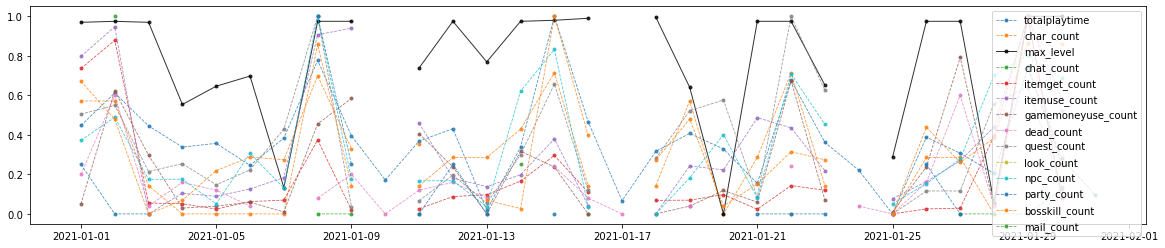

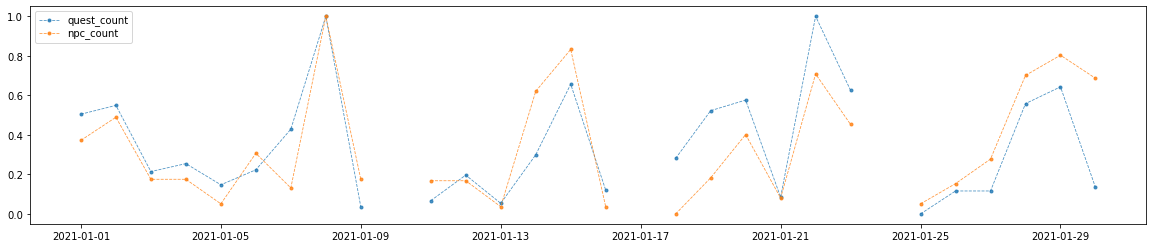

In [376]:
#sc = StandardScaler()
sc = MinMaxScaler()
tmp = game_A[game_A['id'] == '39dd721a537a63ccf9176c6d41d285aa09a1bd2a379276c93715c1eeea214c06']
t = sc.fit_transform(tmp.iloc[:,1:-1])
tmp.iloc[:,1:-1] = t
tmp.index = tmp['sdate']
tmp = tmp.drop(['sdate', 'id'], axis=1)

plt.figure(figsize=(20,4))
for col in tmp.columns:
    if col == 'max_level':
        plt.plot(tmp[col], label=col, color='black', alpha=.8, linewidth=1.0, linestyle='-', marker='.')
    else:
        plt.plot(tmp[col], label=col, alpha=.8, linewidth=.8, linestyle='--', marker='.')
plt.legend()
plt.show()

plt.figure(figsize=(20,4))
for col in ['quest_count', 'npc_count']:#['max_level', 'itemget_count', 'itemuse_count','npc_count', 'gamemoneyuse_count']:
    if col == 'max_level':
        plt.plot(tmp[col], label=col, color='black', alpha=.8, linewidth=1.0, linestyle='-', marker='.')
    else:
        plt.plot(tmp[col], label=col, alpha=.8, linewidth=.8, linestyle='--', marker='.')
plt.legend(loc='upper left', labelspacing=.2)#, frameon=False)
plt.show()

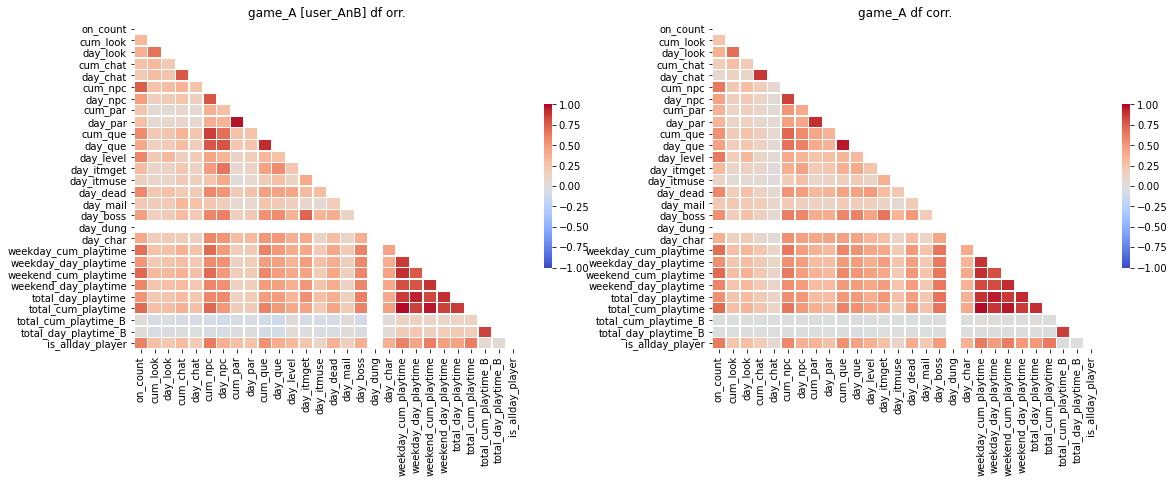

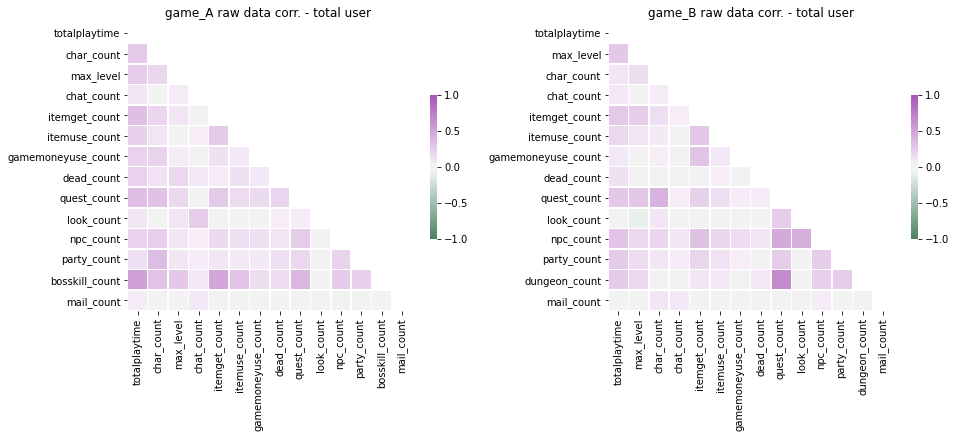

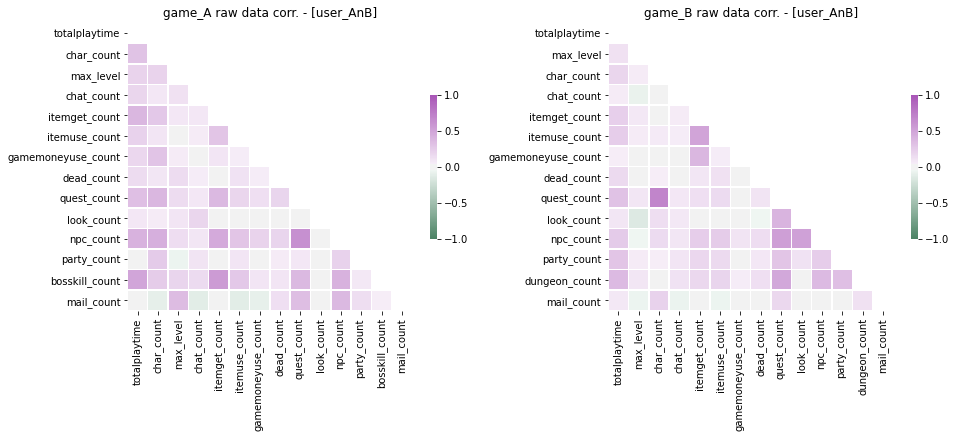

In [116]:
plt.figure(figsize=(15,5))
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

plt.subplot(1,2,1)
mask = np.triu(np.ones_like(game_A.corr(), dtype=bool))
sns.heatmap(game_A.corr(), mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_A raw data corr. - total user ")

plt.subplot(1,2,2)
mask = np.triu(np.ones_like(game_B.corr(), dtype=bool))
sns.heatmap(game_B.corr(), mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_B raw data corr. - total user")
plt.savefig(os.path.join(data_dir, 'raw_data_corr_mat.png'))
plt.show()

plt.figure(figsize=(15,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)

plt.subplot(1,2,1)
mask = np.triu(np.ones_like(game_A.loc[_ind_A].corr(), dtype=bool))
sns.heatmap(game_A.loc[_ind_A].corr(), mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_A raw data corr. - [user_AnB]")

plt.subplot(1,2,2)
mask = np.triu(np.ones_like(game_B.loc[_ind_B].corr(), dtype=bool))
sns.heatmap(game_B.loc[_ind_B].corr(), mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.title("game_B raw data corr. - [user_AnB]")
plt.savefig(os.path.join(data_dir, 'raw_data_AnB_corr_mat.png'))
plt.show()

In [ ]:
* user_AnB의 특징:
    'npc_count'와 'quest_count'가 관련 높음 -- 'npc_count', 'quest_count' 둘 다 높거나 둘 다 낮은 유저들
     user_AnB 중 'look_count'와 'quest_count'

In [90]:
print("max_level:", pd.DataFrame(game_A['max_level'].describe())[max]['max'])

max_level = pd.DataFrame(game_A['max_level'].describe())[max]['max']
max_level_id = game_A[game_A['max_level'] == max_level]['id']

#print(pd.DataFrame(game_A['max_level'].groupby(game_A['id']).mean()).describe()[max]['max'])

df_A.loc[set(max_level_id),:]

max_level: 280.0


,on_count,cum_look,day_look,cum_chat,day_chat,cum_npc,day_npc,cum_par,day_par,cum_que,day_que,weekday_cum_playtime,weekday_day_playtime,weekend_cum_playtime,weekend_day_playtime,total_day_playtime,total_cum_playtime,total_cum_playtime_B
d078a14d815d1fbf5f797c8c82026d27db78cc36f34e90f0e8a9bddc63bda3c4,31.0,25.0,25.000000,1293.0,44.586207,2991.0,96.483871,105.0,4.038462,26581.0,857.451613,22889.0,1089.952381,11586.0,1158.6,1112.096774,34475.0,NaN
68ac5e861dae4b5b8cd4b819f18329c7a657e64db0c30794b8158a85cecfde2b,31.0,31.0,3.444444,2094.0,69.800000,2096.0,67.612903,21.0,1.312500,5641.0,181.967742,28374.0,1351.142857,13829.0,1382.9,1361.387097,42203.0,NaN
0d7a75923f0e922d64e228dd6e056ed6bc642f9078220451ce85d1190596d962,31.0,46.0,7.666667,4833.0,155.903226,1944.0,62.709677,45.0,1.800000,9897.0,319.258065,27786.0,1323.142857,14019.0,1401.9,1348.548387,41805.0,NaN


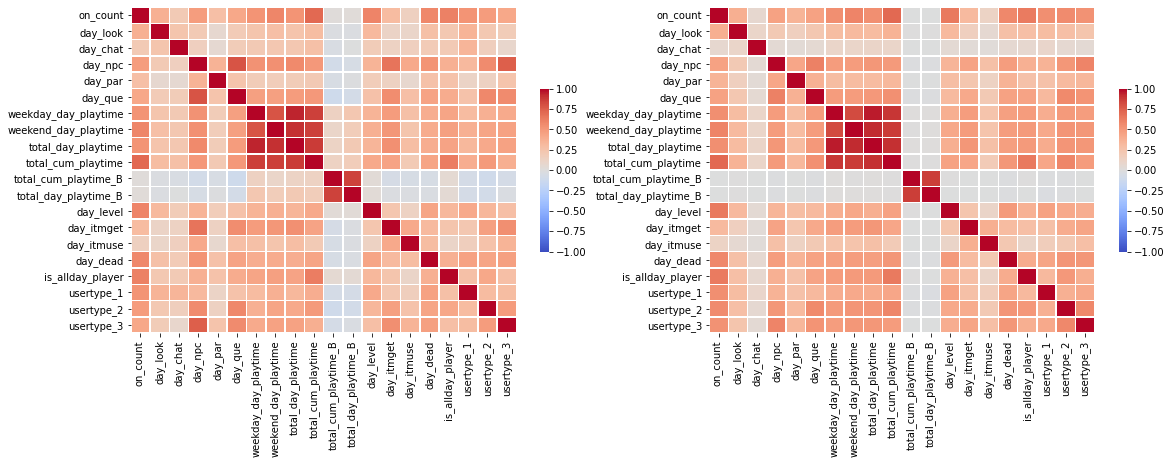

In [378]:
day_features = []
for col in df_A.columns:
    if col.startswith('cum_'):
        pass
    else:
        if col not in ['weekday_cum_playtime', 'weekend_cum_playtime']:
            day_features.append(col)

import seaborn as sns
plt.figure(figsize=(19,6))
plt.subplot(1,2,1)
sns.heatmap(A.loc[user_AnB,day_features].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)

plt.subplot(1,2,2)
sns.heatmap(A.loc[:,day_features].corr(), cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5},  vmin = -1, vmax = 1)
plt.show()

In [42]:
did_map

{'id': '유저 고유 번호',
 'sdate': '데이터 수집 일자',
 'totalplaytime': '일일 누적 플레이시간(분)',
 'char_count': '일일 접속한 캐릭터 수',
 'max_level': '일일 접속 캐릭터 중 최고 레벨',
 'chat_count': '일일 채팅횟수 총합',
 'itemget_count': '일일 아이템 획득횟수 총합',
 'itemuse_count': '일일 아이템 사용횟수 총합',
 'gamemoneyuse_count': '일일 게임 재화 사용횟수',
 'dead_count': '일일 캐릭터 사망횟수 총합',
 'look_count': '일일 외형 변경횟수 총합',
 'npc_count': '일일 npc 상호작용 총합',
 'party_count': '일일 파티 생성횟수 총합',
 'bosskill_count': '일일 보스몬스터 처치횟수 총합',
 'dungeon_count': '일일 던전 입장횟수 총합',
 'mail_count': '일일 메일 전송횟수 총합',
 'quest_count': '일일 퀘스트 완료횟수 총합',
 'match_count': '일일 게임 플레이횟수 총합',
 nan: nan}